# IDH

In [6]:
%matplotlib inline
import pandas as pd
import requests as req
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind, ttest_rel
from scipy.stats import gaussian_kde
from statsmodels.formula.api import ols, mixedlm, gee
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.regression.linear_model import OLSResults
from patsy import dmatrix

np.set_printoptions(precision=3)

### Carregando dados de IDH-M da Wikipedia

#### Fontes

Estados: http://pt.wikipedia.org/wiki/Lista_de_unidades_federativas_do_Brasil_por_IDH

In [7]:
idhm_df = pd.read_csv("../data/brazil_states_idh_2000_2010.csv", index_col=0)
idhm_df

,Estado,I2000,I2010,Ratio,idh_level_2000
0,Distrito Federal,0.725,0.824,1.136552,1
1,São Paulo,0.702,0.783,1.115385,1
2,Santa Catarina,0.674,0.774,1.148368,1
3,Rio de Janeiro,0.664,0.761,1.146084,1
4,Paraná,0.650,0.749,1.152308,1
5,Rio Grande do Sul,0.664,0.746,1.123494,1
6,Espírito Santo,0.640,0.740,1.156250,1
7,Goiás,0.615,0.735,1.195122,1
8,Minas Gerais,0.624,0.731,1.171474,1
9,Mato Grosso do Sul,0.613,0.729,1.189233,1


### Análise

In [8]:
idhm_df.describe()

,I2000,I2010,Ratio,idh_level_2000
count,27.000000,27.000000,27.000000,27.000000
mean,0.576407,0.704519,1.230795,0.518519
std,0.072960,0.049284,0.072885,0.509175
min,0.471000,0.631000,1.115385,0.000000
25%,0.517500,0.664000,1.163862,0.000000
50%,0.552000,0.699000,1.237132,1.000000
75%,0.632000,0.737500,1.286989,1.000000
max,0.725000,0.824000,1.342437,1.000000


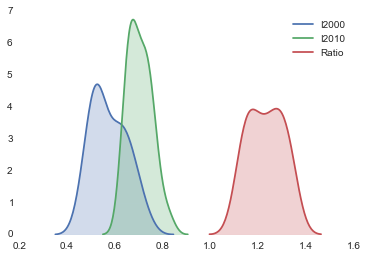

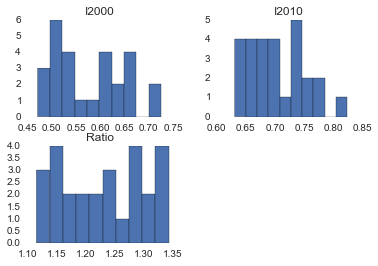

In [9]:
f = plt.figure(14)
idhm_df[["I2000","I2010","Ratio"]].hist(bins=10)
plt.figure()
sns.kdeplot(idhm_df["I2000"], shade=True);
sns.kdeplot(idhm_df["I2010"], shade=True);
sns.kdeplot(idhm_df["Ratio"], shade=True);

### Testando hipótese

#### A diferença média entre os IDHs de 2000 e 2010 é estatisticamente significativa?

In [10]:
ttest_rel(idhm_df['I2000'], idhm_df['I2010'])

(-24.939064182558973, 1.1042795294978035e-19)

In [11]:
import scipy  
import scikits.bootstrap as bootstrap
  
# compute 95% confidence intervals around the mean  
CIs00 = bootstrap.ci(data=idhm_df["I2000"])  
CIs10 = bootstrap.ci(data=idhm_df["I2010"])
CIsR  = bootstrap.ci(data=idhm_df["Ratio"])

print("IDHM 2000 mean 95% confidence interval. Low={0:.3f}\tHigh={1:.3f}".format(*tuple(CIs00)))
print("IDHM 2010 mean 95% confidence interval. Low={0:.3f}\tHigh={1:.3f}".format(*tuple(CIs10)))
print("IDHM ratio mean 95% confidence interval. Low={0:.3f}\tHigh={1:.3f}".format(*tuple(CIsR)))

IDHM 2000 mean 95% confidence interval. Low=0.551	High=0.605
IDHM 2010 mean 95% confidence interval. Low=0.688	High=0.724
IDHM ratio mean 95% confidence interval. Low=1.204	High=1.258


In [12]:
CIs00 = bootstrap.ci(data=idhm_df["I2000"], statfunction=scipy.median)  
CIs10 = bootstrap.ci(data=idhm_df["I2010"], statfunction=scipy.median)
CIsR  = bootstrap.ci(data=idhm_df["Ratio"], statfunction=scipy.median)

print("IDHM 2000 median 95% confidence interval. Low={0:.3f}\tHigh={1:.3f}".format(*tuple(CIs00)))
print("IDHM 2010 median 95% confidence interval. Low={0:.3f}\tHigh={1:.3f}".format(*tuple(CIs10)))
print("IDHM ratio median 95% confidence interval. Low={0:.3f}\tHigh={1:.3f}".format(*tuple(CIsR)))

IDHM 2000 median 95% confidence interval. Low=0.518	High=0.613
IDHM 2010 median 95% confidence interval. Low=0.665	High=0.729
IDHM ratio median 95% confidence interval. Low=1.171	High=1.282


A resposta de diversos testes, para um nível de 5% de significância, mostra que há fortes evidências que **sim**.

### Montando percentual de impacto da administração de cada partido em cada Estado da Federação.

In [13]:
state_parties_df = pd.read_csv("../data/brazil_states_parties_2000-2010.csv", index_col=0)


In [14]:
state_parties_df

,Estado,Outros,PSDB,PT
0,Distrito Federal,1.000,0.000,0.000
1,São Paulo,0.075,0.925,0.000
2,Santa Catarina,1.000,0.000,0.000
3,Rio de Janeiro,0.600,0.000,0.400
4,Paraná,1.000,0.000,0.000
5,Rio Grande do Sul,0.400,0.400,0.200
6,Espírito Santo,0.800,0.200,0.000
7,Goiás,0.400,0.600,0.000
8,Minas Gerais,0.200,0.800,0.000
9,Mato Grosso do Sul,0.400,0.600,0.000


In [15]:
state_regions_df = pd.read_csv("../data/brazil_states_regions.csv", index_col=0)
state_regions_df

,Estado,Regiao
0,Distrito Federal,Centro-Oeste
1,São Paulo,Sudeste
2,Santa Catarina,Sul
3,Rio de Janeiro,Sudeste
4,Paraná,Sul
5,Rio Grande do Sul,Sul
6,Espírito Santo,Sudeste
7,Goiás,Centro-Oeste
8,Minas Gerais,Sudeste
9,Mato Grosso do Sul,Centro-Oeste


In [16]:
df = idhm_df.merge(state_parties_df, on="Estado")
df = df.merge(state_regions_df, on="Estado")
df

,Estado,I2000,I2010,Ratio,idh_level_2000,Outros,PSDB,PT,Regiao
0,Distrito Federal,0.725,0.824,1.136552,1,1.000,0.000,0.000,Centro-Oeste
1,São Paulo,0.702,0.783,1.115385,1,0.075,0.925,0.000,Sudeste
2,Santa Catarina,0.674,0.774,1.148368,1,1.000,0.000,0.000,Sul
3,Rio de Janeiro,0.664,0.761,1.146084,1,0.600,0.000,0.400,Sudeste
4,Paraná,0.650,0.749,1.152308,1,1.000,0.000,0.000,Sul
5,Rio Grande do Sul,0.664,0.746,1.123494,1,0.400,0.400,0.200,Sul
6,Espírito Santo,0.640,0.740,1.156250,1,0.800,0.200,0.000,Sudeste
7,Goiás,0.615,0.735,1.195122,1,0.400,0.600,0.000,Centro-Oeste
8,Minas Gerais,0.624,0.731,1.171474,1,0.200,0.800,0.000,Sudeste
9,Mato Grosso do Sul,0.613,0.729,1.189233,1,0.400,0.600,0.000,Centro-Oeste


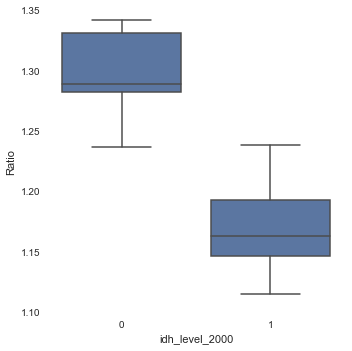

In [17]:
sns.factorplot("idh_level_2000","Ratio",data=df, kind="box")

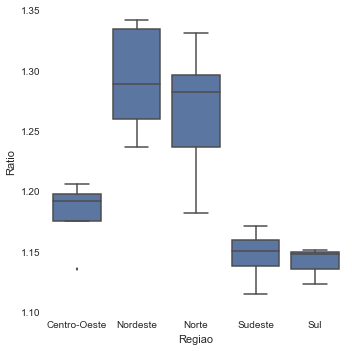

In [18]:
sns.factorplot("Regiao","Ratio",data=df, kind="box")

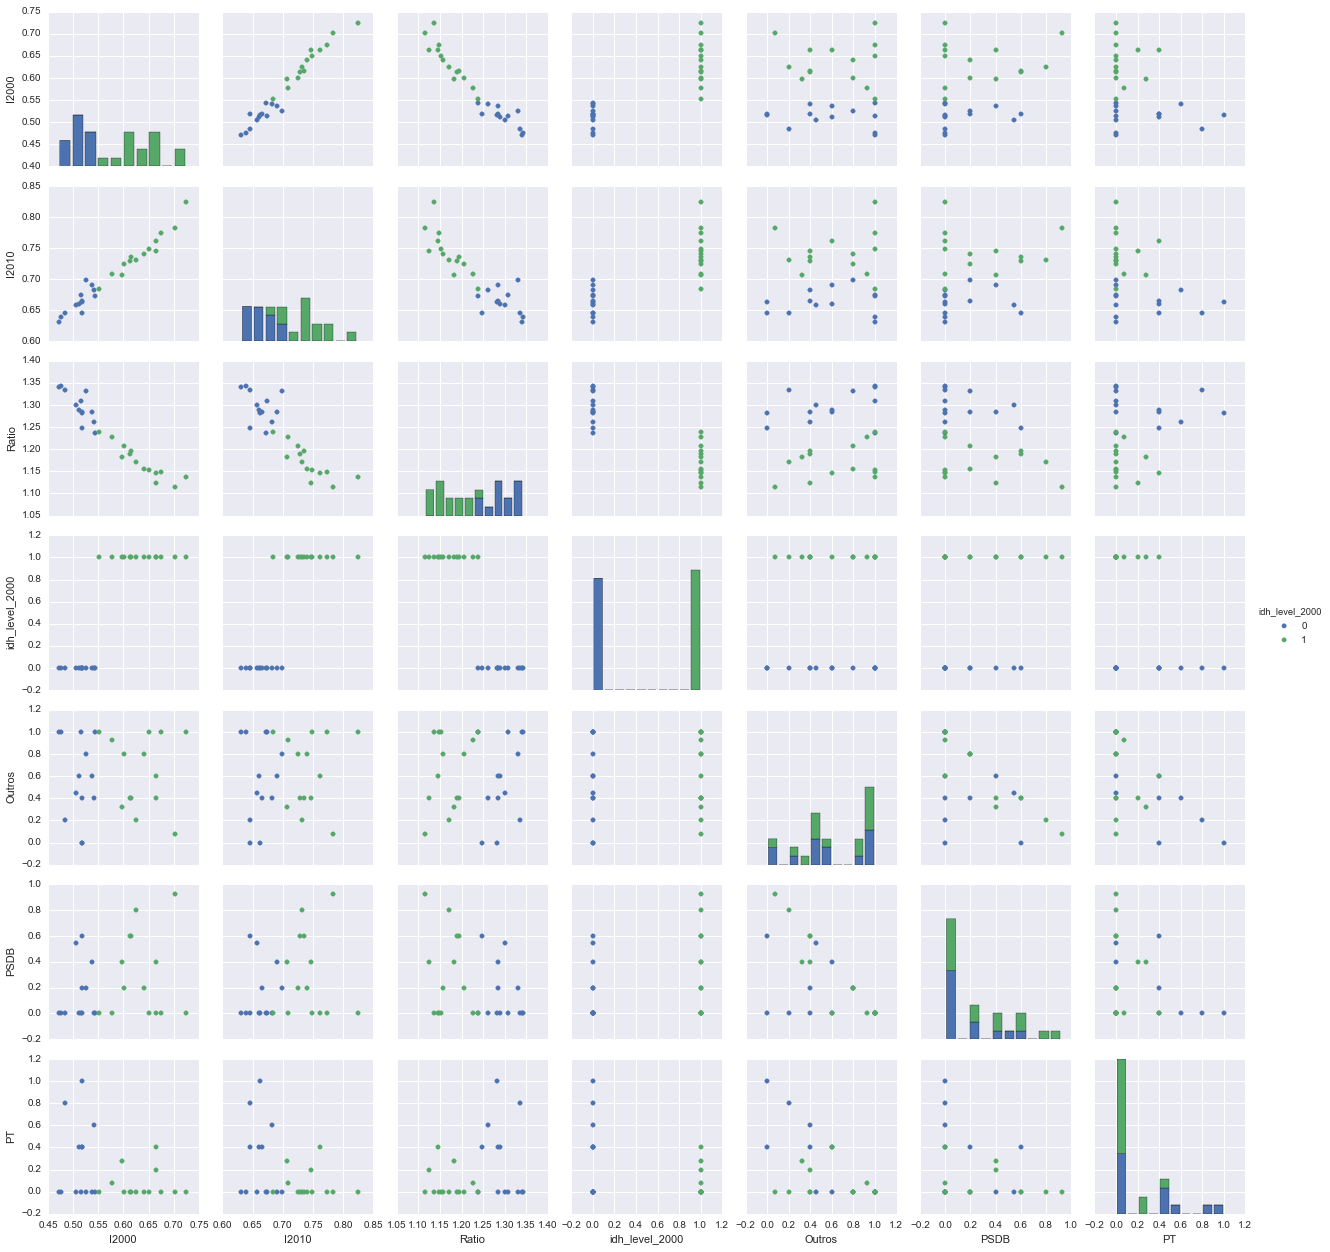

In [19]:
sns.set()
sns.pairplot(df, hue="idh_level_2000", size=2.5)

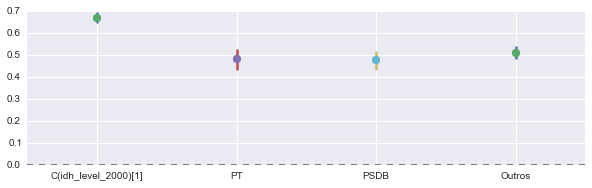

In [20]:
sns.coefplot("Ratio ~ PT + PSDB + Outros + C(idh_level_2000) - 1", df, palette="Set1");

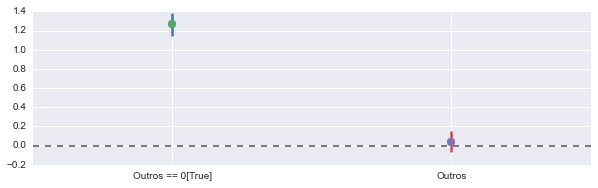

In [21]:
sns.coefplot("Ratio ~ Outros==0 + Outros - 1", df, palette="Set1");

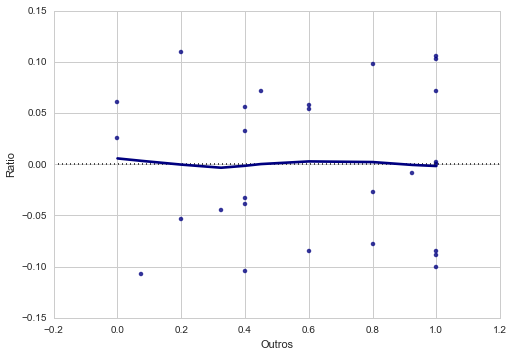

In [22]:
sns.set(style="whitegrid")
sns.residplot(df.Outros,df.Ratio, color="navy", lowess=True, order=1)

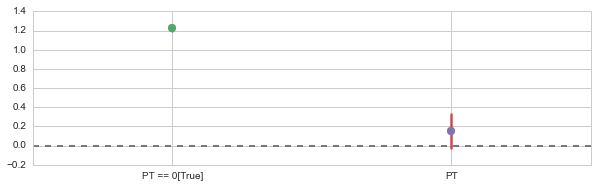

In [23]:
sns.coefplot("Ratio ~ PT==0 + PT - 1", df, palette="Set1");

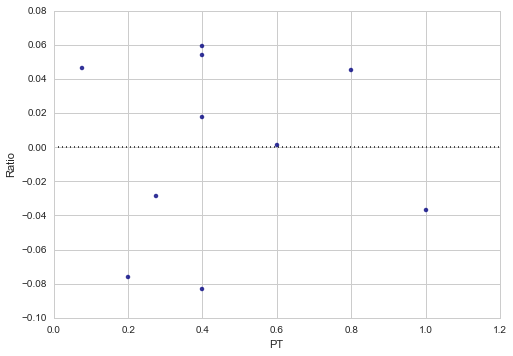

In [24]:
sns.set(style="whitegrid")
sns.residplot(df[df.PT>0].PT, df[df.PT>0].Ratio, color="navy", order=1)

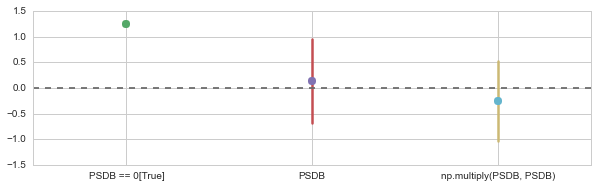

In [25]:
sns.coefplot("Ratio ~ PSDB==0 + PSDB + np.multiply(PSDB, PSDB) - 1", df, palette="Set1");

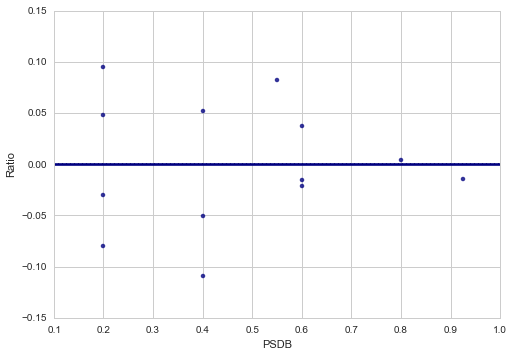

In [26]:
sns.set(style="whitegrid")
sns.residplot(df[df.PSDB>0].PSDB, df[df.PSDB>0].Ratio, color="navy", lowess=True, order=2)

### Impacto por partido ou nível do IDH-M em 2000

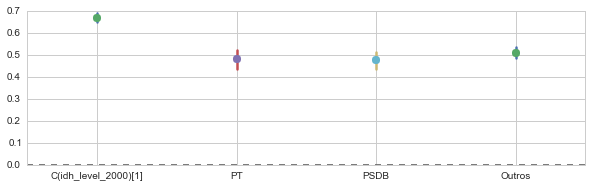

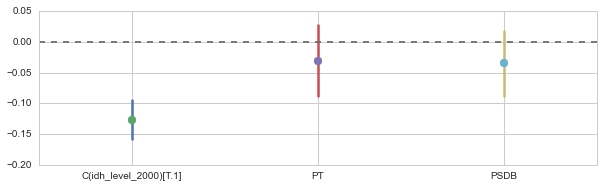

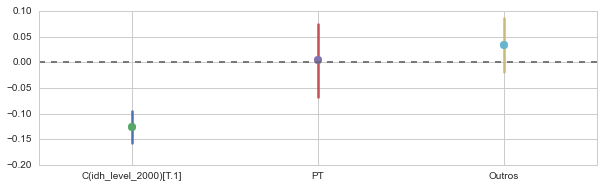

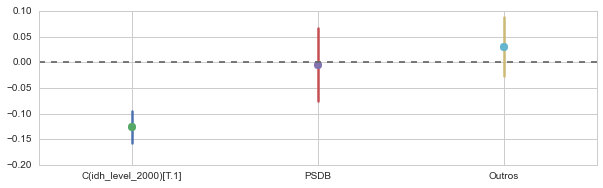

In [27]:
sns.coefplot("Ratio ~ PT + PSDB + Outros + C(idh_level_2000) - 1", df, palette="Set1");
sns.coefplot("Ratio ~ PT + PSDB + C(idh_level_2000)", df, palette="Set1");
sns.coefplot("Ratio ~ PT + Outros + C(idh_level_2000)", df, palette="Set1");
sns.coefplot("Ratio ~ PSDB + Outros + C(idh_level_2000)", df, palette="Set1");

In [28]:
formula = "Ratio ~ PT + PSDB + C(idh_level_2000) + C(Regiao)"
model = ols(formula, df).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Ratio   R-squared:                       0.863
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     17.05
Date:                Sun, 10 May 2015   Prob (F-statistic):           5.88e-07
Time:                        00:50:56   Log-Likelihood:                 59.709
No. Observations:                  27   AIC:                            -103.4
Df Residuals:                      19   BIC:                            -93.05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------
Intercept                  1.2728      0.029     44.338      0.000         1.213     1.333
C(idh_level_2000)[T.1]    -0.0824      0.021     -3.866      0.001        -0.127    -0.038
C(Regiao)[T.Nordeste]      0.0374      0.028      1.352      0.192        -0.020     0.095
C(Regiao)[T.Norte]         0.0299      0.025      1.187      0.250        -0.023     0.083
C(Regiao)[T.Sudeste]      -0.0284      0.023     -1.245      0.228        -0.076     0.019
C(Regiao)[T.Sul]          -0.0438      0.025     -1.771      0.093        -0.096     0.008
PT                        -0.0290      0.025     -1.161      0.260        -0.081     0.023
PSDB                      -0.0246      0.025     -0.968      0.345        -0.078     0.029
==============================================================================
Omnibus:                        4.678   Durbin-Watson:                   1.835
Prob(Omnibus):                  0.096   Jarque-Bera (JB):                2.983
Skew:                          -0.747   Prob(JB):                        0.225
Kurtosis:                       3.647   Cond. No.                         10.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

**Não foi possível observar diferença significantiva entre os partidos.**

### Quais estados possuem diferença significativa?

Comparando 2010 com 2000

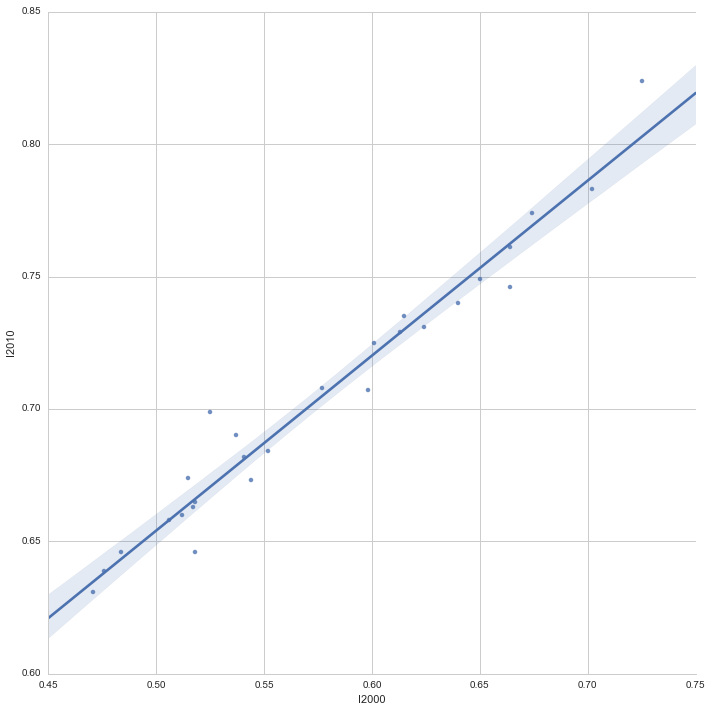

In [29]:
sns.lmplot("I2000", "I2010", data=df, legend=True, size=10, n_boot=10000, ci=95)

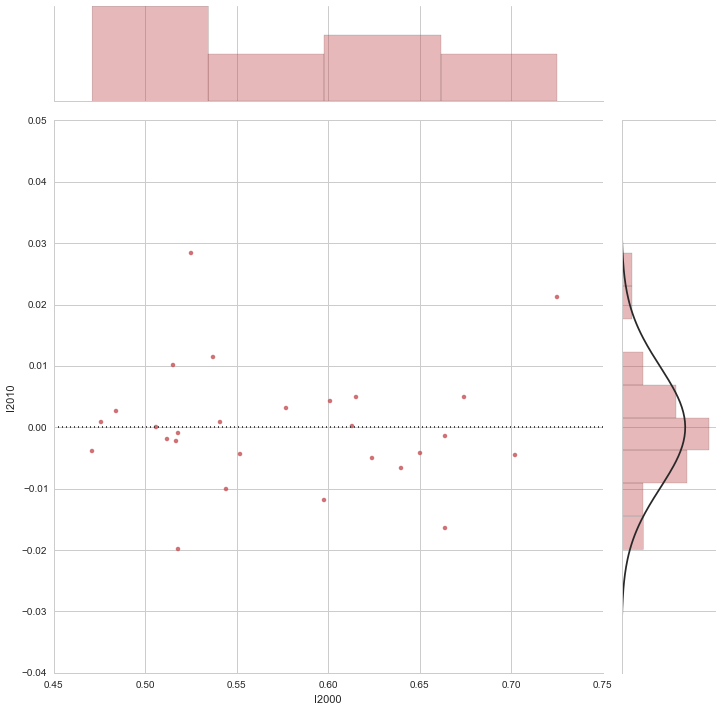

In [30]:
sns.jointplot("I2000", "I2010", data=df, kind='resid',color=sns.color_palette()[2], size=10)

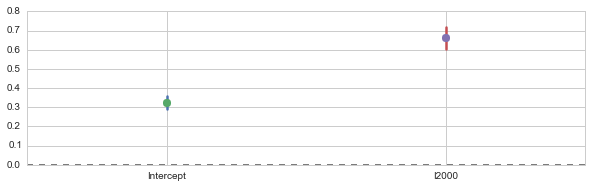

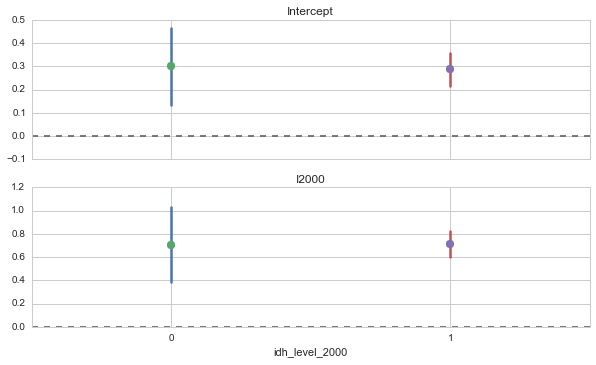

In [31]:
sns.coefplot("I2010 ~ I2000", data=df, intercept=True)
sns.coefplot("I2010 ~ I2000", data=df, groupby="idh_level_2000", intercept=True)

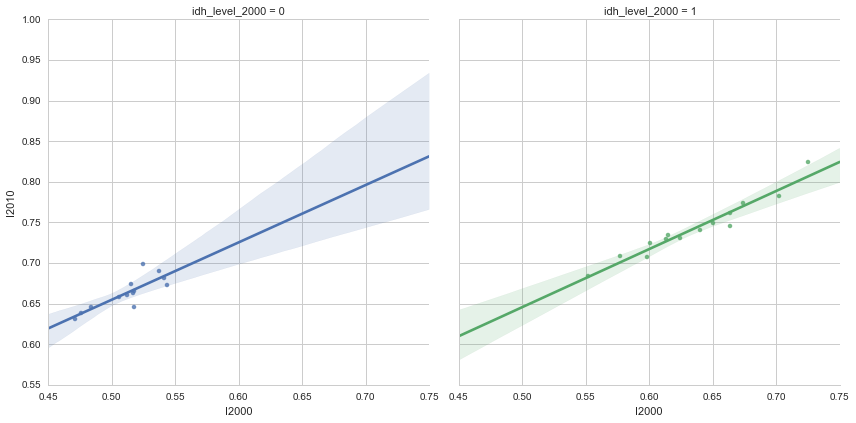

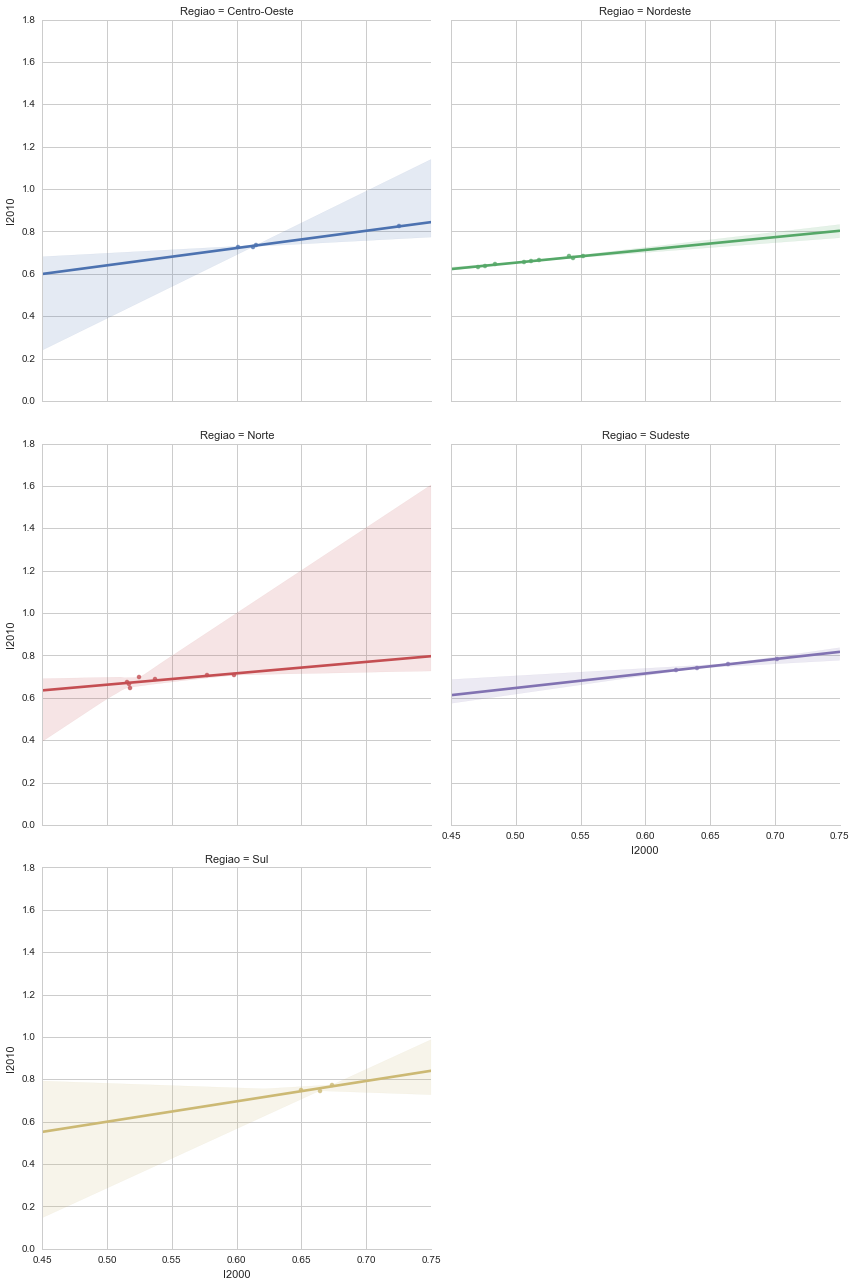

In [32]:
sns.lmplot("I2000", "I2010", data=df, hue="idh_level_2000", col="idh_level_2000", legend=True, size=6, n_boot=10000, ci=99)
sns.lmplot("I2000", "I2010", data=df, hue="Regiao", col="Regiao", col_wrap=2, legend=True, size=6, n_boot=10000, ci=99)

In [33]:
md = ols("I2010 ~ I2000 + C(Regiao)", df).fit()
print(md.summary())

                            OLS Regression Results                            
Dep. Variable:                  I2010   R-squared:                       0.966
Model:                            OLS   Adj. R-squared:                  0.958
Method:                 Least Squares   F-statistic:                     119.0
Date:                Sun, 10 May 2015   Prob (F-statistic):           1.13e-14
Time:                        00:51:10   Log-Likelihood:                 89.081
No. Observations:                  27   AIC:                            -166.2
Df Residuals:                      21   BIC:                            -158.4
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-----------------------------------------------------------------------------------------
Intercept                 0.32

In [34]:
rrr = md.get_robustcov_results()
rrp = rrr.outlier_test("fdr_bh", 0.1)
idx = rrp[rrp["fdr_bh(p)"] <= 0.1].index
print("Estados fora da média:\n",df.ix[idx.values])
rrp[rrp["fdr_bh(p)"] <= 0.1]

Estados fora da média:
        Estado  I2000  I2010     Ratio  idh_level_2000  Outros  PSDB  PT Regiao
13  Tocantins  0.525  0.699  1.331429               0     0.8   0.2   0  Norte


,student_resid,unadj_p,fdr_bh(p)
13,3.426862,0.002671,0.072106


### GEE

In [35]:
import statsmodels.api as sm
md = gee("Ratio ~ PT + PSDB ", df.idh_level_2000, df, cov_struct=sm.cov_struct.Exchangeable()) 
mdf = md.fit() 
print(mdf.summary())
print(mdf.cov_struct.summary())

                               GEE Regression Results                              
Dep. Variable:                       Ratio   No. Observations:                   27
Model:                                 GEE   No. clusters:                        2
Method:                        Generalized   Min. cluster size:                  13
                      Estimating Equations   Max. cluster size:                  14
Family:                           Gaussian   Mean cluster size:                13.5
Dependence structure:         Exchangeable   Num. iterations:                     6
Date:                     Sun, 10 May 2015   Scale:                           0.006
Covariance type:                    robust   Time:                         00:51:10
                 coef    std err          z      P>|z|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept      1.2459      0.045     27.434      0.000         1.157     1.335
PT     

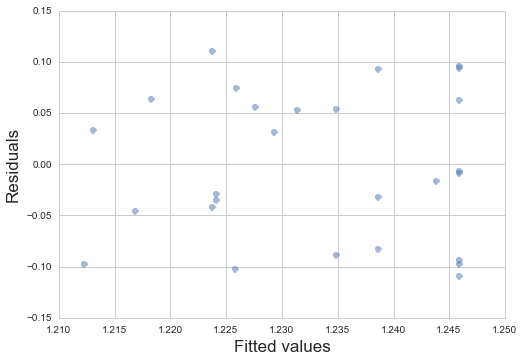

In [36]:
plt.plot(mdf.fittedvalues, mdf.resid, 'o', alpha=0.5)
plt.xlabel("Fitted values", size=17)
plt.ylabel("Residuals", size=17)

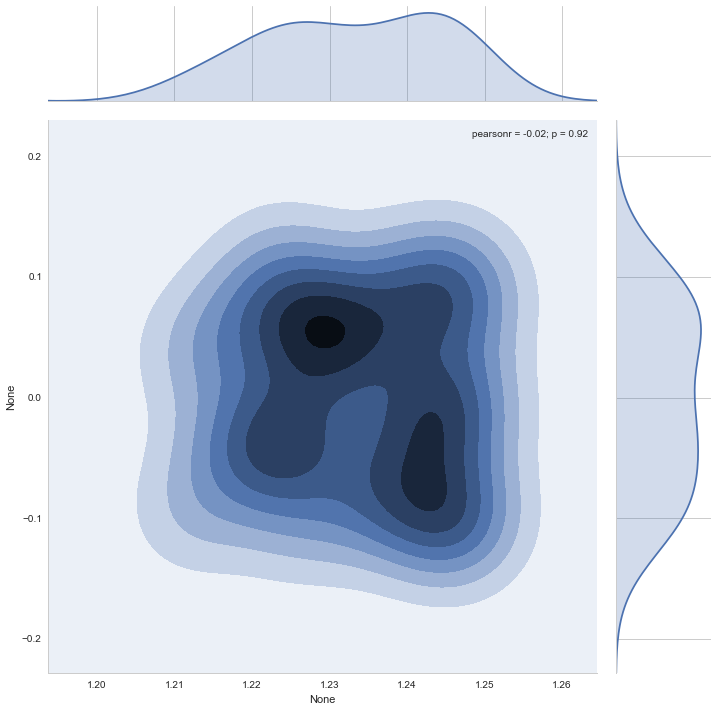

In [37]:
sns.jointplot(mdf.fittedvalues, mdf.resid, size=10, kind="kde")